The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Random index: 17337
(1024, 1024, 1) [ 5  1 14]
(512, 512, 1) [ 5  1 14]
(1, 512, 512) [ 5  1 14]
torch.Size([1, 512, 512]) [ 5  1 14] torch.float32
Disease: effusion, consolidation, infiltration
질병: effusion, 확률: 29.30%
질병: consolidation, 확률: 13.00%
질병: infiltration, 확률: 54.80%


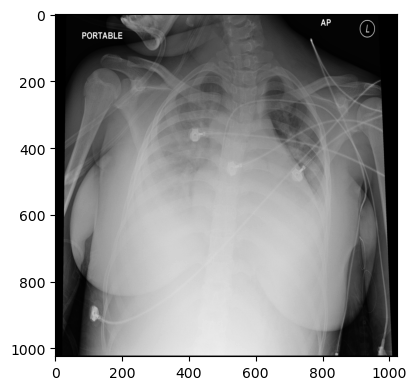

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import torch, cv2
import numpy as np
from functools import partial
from matplotlib import pyplot as plt
import torchxrayvision as xrv
import pandas as pd
import random

from univdt.components import NIH
from univdt.components.nih import MAPPER

def generate_random_index(max_index):
    generated_indexes = set()  # 생성된 인덱스를 추적하기 위한 빈 집합 생성
    while True:
        random_index = random.randint(0, max_index - 1)
        if random_index not in generated_indexes:
            generated_indexes.add(random_index)
            return random_index

root_dir = 'C:\\nih\\nih'  # TODO: 루트 디렉토리 설정
nih = partial(NIH, root_dir=root_dir, transform=None)

nih_test = nih(split='test')
assert len(nih_test) == 25596

# 무작위 인덱스 생성
random_index = generate_random_index(len(nih_test))
print("Random index:", random_index)

data = nih_test.load_data(random_index)
image = data['image']
label = data['label']
print(image.shape, label)

plt.figure(figsize=(15, 5))

# 이미지 resize
image_resized = cv2.resize(image, (512, 512))
image_resized = np.expand_dims(image_resized, axis=2)

print(image_resized.shape, label)

image_resized = xrv.datasets.normalize(image_resized, 255)
image_resized = image_resized.mean(2)[None, ...]
image_resized = image_resized.astype(dtype=np.float32)
print(image_resized.shape, label)
image_resized = torch.from_numpy(image_resized)
print(image_resized.shape, label, image_resized.dtype)

model = xrv.models.ResNet(weights="resnet50-res512-all")
outputs = model(image_resized[None, ...])

# 이미지 출력
plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')

if isinstance(label, np.ndarray):
    diseases = []
    for l in label:
        l = int(l)  # label을 정수로 변환
        if l not in MAPPER.values():
            print(f"Label {l} not found in MAPPER.")
        else:
            disease_name = list(MAPPER.keys())[list(MAPPER.values()).index(l)]
            diseases.append(disease_name)
    unique_diseases = set(diseases)
    title = f'Disease: {", ".join(unique_diseases)}'

else:
    label = int(label)  # label을 정수로 변환
    if label not in MAPPER.values():
        print(f"Label {label} not found in MAPPER.")
        title = "Unknown Disease"
    else:
        disease_name = list(MAPPER.keys())[list(MAPPER.values()).index(label)]
        title = f"Disease: {disease_name}"

print(title)

output_probabilities_dict = dict(zip(diseases, outputs[0].detach().numpy()))
for disease in unique_diseases:
    if disease in output_probabilities_dict:
        probability = output_probabilities_dict[disease]
        probability_percent = round(probability * 100, 1)
        print(f"질병: {disease}, 확률: {probability_percent:.2f}%")
        
plt.show()

In [ ]:
from pprint import pprint 
model = xrv.models.ResNet(weights="resnet50-res512-all")
outputs = model(image[None,...]) # or model.features(img[None,...]) 
pprint(dict(zip(model.pathologies,outputs[0].detach().numpy())))

+----+--------------------+--------+
|    | 질병               |   확률 |
|----+--------------------+--------|
|  1 | Atelectasis        |   2.52 |
|  2 | Consolidation      |   0.64 |
|  3 | Infiltration       |   7.73 |
|  4 | Pneumothorax       |   2.37 |
|  5 | Edema              |   0.06 |
|  6 | Emphysema          |   0.7  |
|  7 | Fibrosis           |   4.71 |
|  8 | Effusion           |   4.34 |
|  9 | Pneumonia          |   0.08 |
| 10 | Pleural_Thickening |  10.13 |
| 11 | Cardiomegaly       |   0.98 |
| 12 | Nodule             |   3.19 |
| 13 | Mass               |   0.62 |
| 14 | Hernia             |   0.07 |
+----+--------------------+--------+


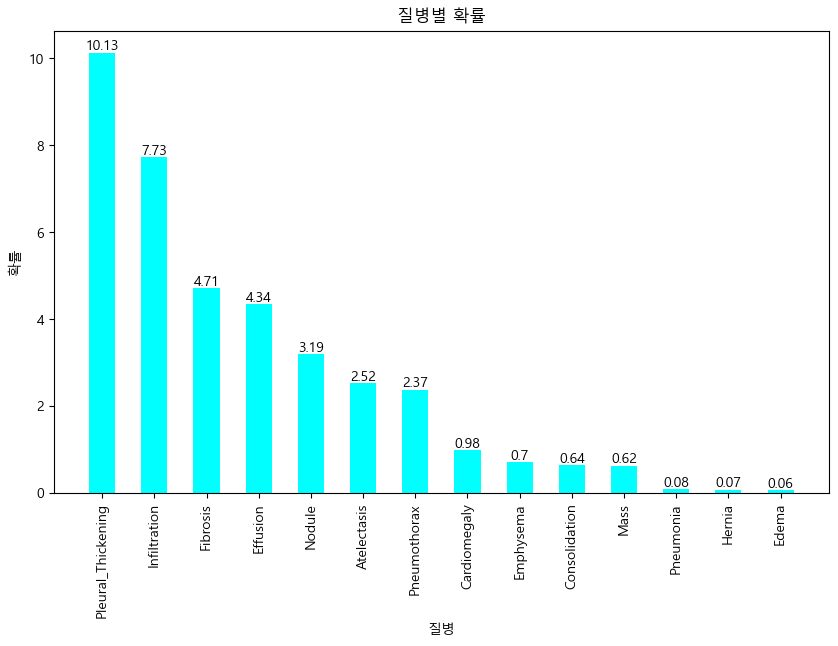

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

plt.rc('font', family='Malgun Gothic')
output_probabilities_dict = dict(zip(model.pathologies, outputs[0].detach().numpy()))

# 결과를 담을 데이터프레임 생성
result_df = pd.DataFrame(columns=['질병', '확률'])

# 데이터프레임에 결과 추가
for disease in output_probabilities_dict:
    if disease not in ["Enlarged Cardiomediastinum", "Lung Lesion", "Lung Opacity", "Fracture"]:
        probability = output_probabilities_dict[disease]
        probability_percent = round(probability * 100, 2)
        result_df = pd.concat([result_df, pd.DataFrame({'질병': [disease], '확률': [probability_percent]})], ignore_index=True)

result_df.index = result_df.index+1

result_df.style.set_properties(subset=pd.IndexSlice[:, :], **{'text-align': 'center'})

# 텍스트 테이블로 출력
print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=True))

# 확률을 기준으로 내림차순 정렬
result_df = result_df.sort_values(by='확률', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(result_df['질병'], result_df['확률'], color='aqua', width=0.5)
plt.title('질병별 확률')
plt.xlabel('질병')
plt.ylabel('확률')
plt.xticks(rotation=90)

# 그래프에 숫자 표시
for i, v in enumerate(result_df['확률']):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()


In [176]:
output_probabilities_dict = dict(zip(model.pathologies, outputs[0].detach().numpy()))
for disease in output_probabilities_dict:
    probability = output_probabilities_dict[disease]
    probability_percent = round(probability * 100, 2)
    print(f"질병: {disease}, 확률: {probability_percent:.2f}%")

질병: Atelectasis, 확률: 1.82%
질병: Consolidation, 확률: 2.20%
질병: Infiltration, 확률: 28.08%
질병: Pneumothorax, 확률: 21.92%
질병: Edema, 확률: 0.41%
질병: Emphysema, 확률: 5.24%
질병: Fibrosis, 확률: 18.24%
질병: Effusion, 확률: 11.24%
질병: Pneumonia, 확률: 0.78%
질병: Pleural_Thickening, 확률: 22.99%
질병: Cardiomegaly, 확률: 0.31%
질병: Nodule, 확률: 3.67%
질병: Mass, 확률: 1.20%
질병: Hernia, 확률: 0.03%
질병: Lung Lesion, 확률: 50.00%
질병: Fracture, 확률: 2.15%
질병: Lung Opacity, 확률: 0.06%
질병: Enlarged Cardiomediastinum, 확률: 50.00%


In [67]:
import pandas as pd

output_probabilities_dict = dict(zip(model.pathologies, outputs[0].detach().numpy()))

# 결과를 담을 데이터프레임 생성
result_df = pd.DataFrame(columns=['질병', '확률'])

# 데이터프레임에 결과 추가
for disease in output_probabilities_dict:
    probability = output_probabilities_dict[disease]
    probability_percent = round(probability * 100, 2)
    result_df = pd.concat([result_df, pd.DataFrame({'질병': [disease], '확률': [f'{probability_percent:.2f}%']})], ignore_index=True)

# 표 형태로 출력
print(result_df)


                            질병      확률
0                  Atelectasis   1.82%
1                Consolidation   2.20%
2                 Infiltration  28.08%
3                 Pneumothorax  21.92%
4                        Edema   0.41%
5                    Emphysema   5.24%
6                     Fibrosis  18.24%
7                     Effusion  11.24%
8                    Pneumonia   0.78%
9           Pleural_Thickening  22.99%
10                Cardiomegaly   0.31%
11                      Nodule   3.67%
12                        Mass   1.20%
13                      Hernia   0.03%
14                 Lung Lesion  50.00%
15                    Fracture   2.15%
16                Lung Opacity   0.06%
17  Enlarged Cardiomediastinum  50.00%


In [68]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')
output_probabilities_dict = dict(zip(model.pathologies, outputs[0].detach().numpy()))

# 결과를 담을 데이터프레임 생성
result_df = pd.DataFrame(columns=['질병', '확률'])

# 데이터프레임에 결과 추가
for disease in output_probabilities_dict:
    if disease not in ["Enlarged Cardiomediastinum", "Lung Lesion", "Lung Opacity", "Fracture"]:
        probability = output_probabilities_dict[disease]
        probability_percent = round(probability * 100, 2)
        result_df = pd.concat([result_df, pd.DataFrame({'질병': [disease], '확률': [f'{probability_percent:.2f}%']})], ignore_index=True)

# 표 형태로 출력
print(result_df)


                    질병      확률
0          Atelectasis   1.82%
1        Consolidation   2.20%
2         Infiltration  28.08%
3         Pneumothorax  21.92%
4                Edema   0.41%
5            Emphysema   5.24%
6             Fibrosis  18.24%
7             Effusion  11.24%
8            Pneumonia   0.78%
9   Pleural_Thickening  22.99%
10        Cardiomegaly   0.31%
11              Nodule   3.67%
12                Mass   1.20%
13              Hernia   0.03%


+----+--------------------+--------+
|    | 질병               |   확률 |
|----+--------------------+--------|
|  1 | Atelectasis        |  16.67 |
|  2 | Consolidation      |   3.71 |
|  3 | Infiltration       |  49.02 |
|  4 | Pneumothorax       |   0.09 |
|  5 | Edema              |   0.02 |
|  6 | Emphysema          |   5.15 |
|  7 | Fibrosis           |   6.41 |
|  8 | Effusion           |   0.59 |
|  9 | Pneumonia          |   3.44 |
| 10 | Pleural_Thickening |   1.53 |
| 11 | Cardiomegaly       |   0.02 |
| 12 | Nodule             |  15.82 |
| 13 | Mass               |   1.36 |
| 14 | Hernia             |   0.05 |
+----+--------------------+--------+


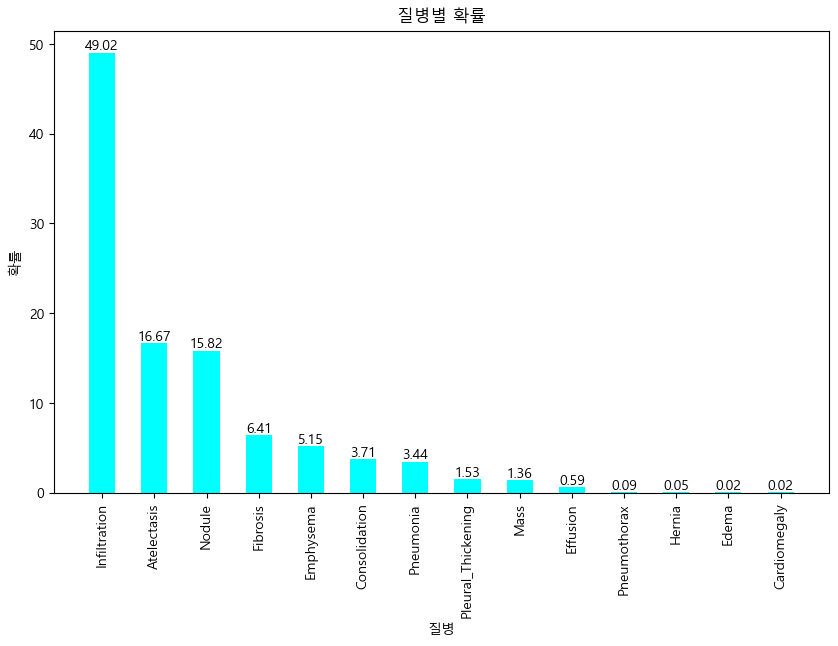

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

plt.rc('font', family='Malgun Gothic')
output_probabilities_dict = dict(zip(model.pathologies, outputs[0].detach().numpy()))

# 결과를 담을 데이터프레임 생성
result_df = pd.DataFrame(columns=['질병', '확률'])

# 데이터프레임에 결과 추가
for disease in output_probabilities_dict:
    if disease not in ["Enlarged Cardiomediastinum", "Lung Lesion", "Lung Opacity", "Fracture"]:
        probability = output_probabilities_dict[disease]
        probability_percent = round(probability * 100, 2)
        result_df = pd.concat([result_df, pd.DataFrame({'질병': [disease], '확률': [probability_percent]})], ignore_index=True)

result_df.index = result_df.index+1

result_df.style.set_properties(subset=pd.IndexSlice[:, :], **{'text-align': 'center'})

# 텍스트 테이블로 출력
print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=True))

# 확률을 기준으로 내림차순 정렬
result_df = result_df.sort_values(by='확률', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(result_df['질병'], result_df['확률'], color='aqua', width=0.5)
plt.title('질병별 확률')
plt.xlabel('질병')
plt.ylabel('확률')
plt.xticks(rotation=90)

# 그래프에 숫자 표시
for i, v in enumerate(result_df['확률']):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()


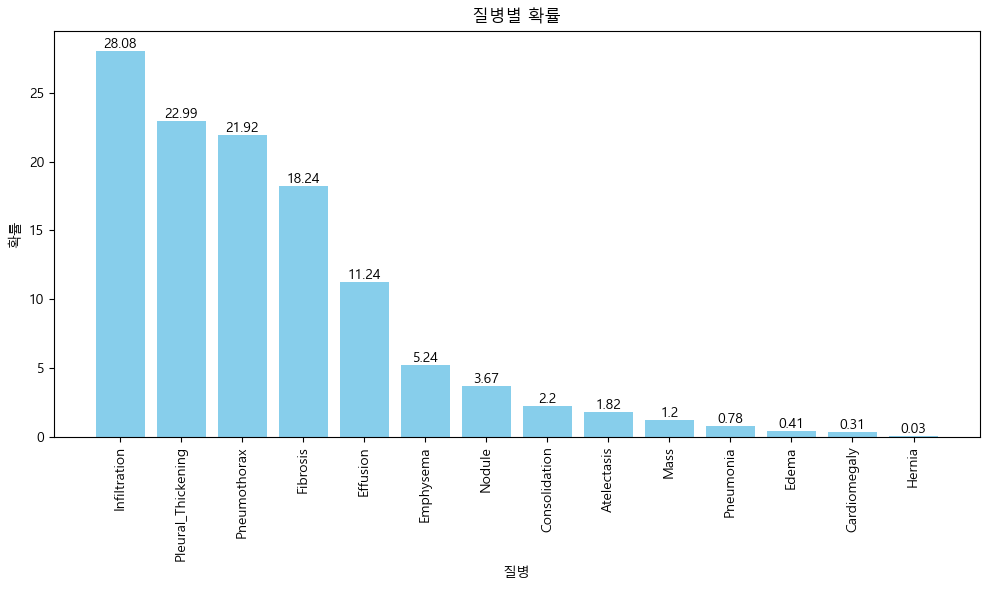

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')

%matplotlib inline

df = pd.DataFrame({
    '질병': ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis',
            'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'],
    '확률': [1.82, 2.20, 28.08, 21.92, 0.41, 5.24, 18.24, 11.24, 0.78, 22.99, 0.31, 3.67, 1.20, 0.03]
})

# 확률을 기준으로 내림차순 정렬
df = df.sort_values(by='확률', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(df['질병'], df['확률'], color='skyblue')
plt.xlabel('질병')
plt.ylabel('확률')
plt.title('질병별 확률')
plt.xticks(rotation=90)
plt.tight_layout()

# 그래프에 숫자 표시
for i, v in enumerate(result_df['확률']):
    plt.text(i, v, str(v), ha='center', va='bottom')

# 그래프 출력
plt.show()


                    질병      확률
0          Atelectasis   1.82%
1        Consolidation   2.20%
2         Infiltration  28.08%
3         Pneumothorax  21.92%
4                Edema   0.41%
5            Emphysema   5.24%
6             Fibrosis  18.24%
7             Effusion  11.24%
8            Pneumonia   0.78%
9   Pleural_Thickening  22.99%
10        Cardiomegaly   0.31%
11              Nodule   3.67%
12                Mass   1.20%
13              Hernia   0.03%


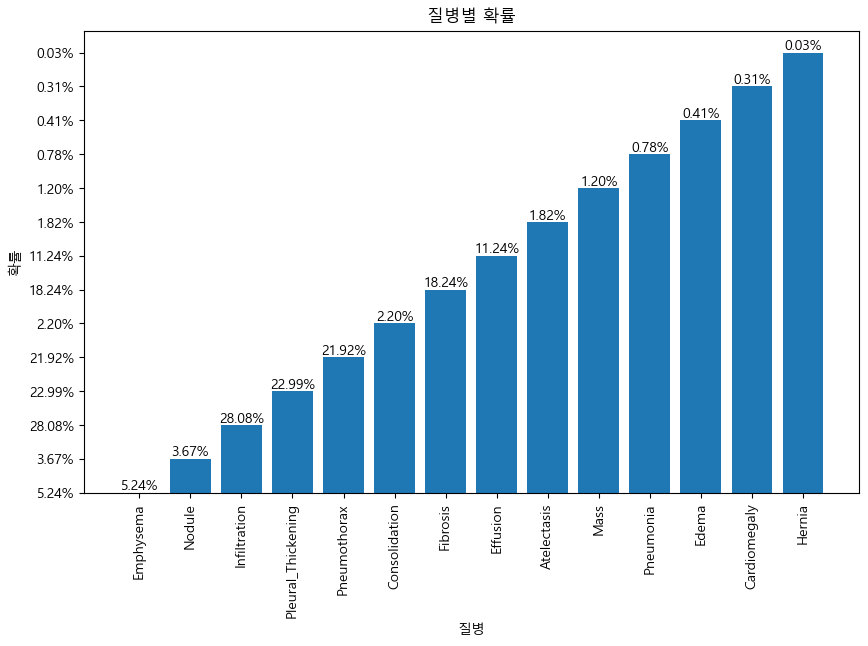

In [75]:
output_probabilities_dict = dict(zip(model.pathologies, outputs[0].detach().numpy()))

# 결과를 담을 데이터프레임 생성
result_df = pd.DataFrame(columns=['질병', '확률'])

# 데이터프레임에 결과 추가
for disease in output_probabilities_dict:
    if disease not in ["Enlarged Cardiomediastinum", "Lung Lesion", "Lung Opacity", "Fracture"]:
        probability = output_probabilities_dict[disease]
        probability_percent = round(probability * 100, 2)
        result_df = pd.concat([result_df, pd.DataFrame({'질병': [disease], '확률': [f'{probability_percent:.2f}%']})], ignore_index=True)

# 숫자 인덱스 제거
result_df = result_df.reset_index(drop=True)

# 표 형태로 출력
print(result_df)

result_df = result_df.sort_values(by='확률', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(result_df['질병'], result_df['확률'])
plt.title('질병별 확률')
plt.xlabel('질병')
plt.ylabel('확률')
plt.xticks(rotation=90)

# 그래프에 숫자 표시
for i, v in enumerate(result_df['확률']):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()


In [143]:
# 모델의 출력값으로부터 확률 값을 가져오는 코드
output_probabilities = [output_probabilities_dict[label] for label in model.pathologies]

# 확률 값을 100으로 곱하고 소수점 2자리까지 반올림하는 코드
probabilities_percent = [round(p * 100, 2) for p in output_probabilities]

# 레이블과 해당 레이블에 대한 확률 값을 출력하는 코드
for label, percent in zip(model.pathologies, probabilities_percent):
    print(f"질병 : {label}, 확률 : {percent}%")

질병 : Atelectasis, 확률 : 1.82%
질병 : Consolidation, 확률 : 2.2%
질병 : Infiltration, 확률 : 28.08%
질병 : Pneumothorax, 확률 : 21.92%
질병 : Edema, 확률 : 0.41%
질병 : Emphysema, 확률 : 5.24%
질병 : Fibrosis, 확률 : 18.24%
질병 : Effusion, 확률 : 11.24%
질병 : Pneumonia, 확률 : 0.78%
질병 : Pleural_Thickening, 확률 : 22.99%
질병 : Cardiomegaly, 확률 : 0.31%
질병 : Nodule, 확률 : 3.67%
질병 : Mass, 확률 : 1.2%
질병 : Hernia, 확률 : 0.03%
질병 : Lung Lesion, 확률 : 50.0%
질병 : Fracture, 확률 : 2.15%
질병 : Lung Opacity, 확률 : 0.06%
질병 : Enlarged Cardiomediastinum, 확률 : 50.0%
